# Stochastic Variational Sparse Gaussian Process Classification (白色化なし)

---

## セットアップ

### モジュールの読み込み

In [1]:
import numpy as np
import torch
import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [2]:
import sys
sys.path.append("../")

from models import SVSGP
from kernels import RBF
from likelihoods import Binary

In [3]:
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize

### 設定

In [4]:
# 乱数シードを固定
pyro.set_rng_seed(4)

In [5]:
# テンソルのdtypeをデフォルトで倍精度に設定
torch.set_default_dtype(torch.float64)

---

## データの生成

In [6]:
centroids = torch.rand(10, 2) * 10 - 5
X = torch.tile(centroids, (10, 1)) + torch.rand(100, 2) * 3 - 1.5
y = torch.tensor([1 if i % 2 == 0 else 0 for i in range(X.shape[0])], dtype = torch.get_default_dtype()).unsqueeze(1)

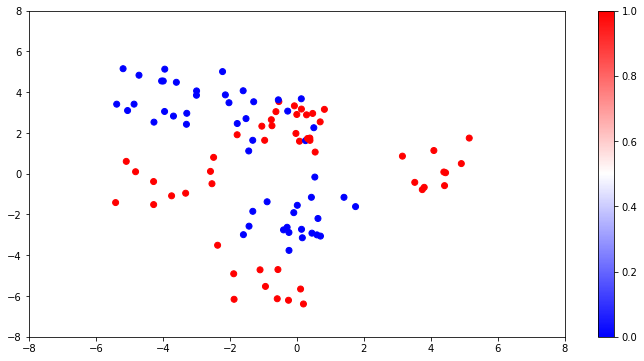

In [7]:
plt.figure(figsize = (12, 6))
plt.scatter(x = X[:, 0], y = X[:, 1], c = y[:, 0], cmap = "bwr")
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.colorbar()
plt.show()

---

## 推論

In [8]:
pyro.clear_param_store()

kernel = RBF()
likelihood = Binary()
Z = X[:20, :].clone()
estimator = SVSGP(Z, 1, kernel, likelihood, whiten = False, subsample_size = 10)

svi = SVI(
    estimator.model,
    estimator.guide,
    Adam({"lr": 0.01}),
    loss = Trace_ELBO(retain_graph = True)
)

n_steps = 1000
for step in range(n_steps):
    loss = svi.step(X, y)
    if step % (n_steps / 10) == 0:
        print(loss)

7800.032519532715
5043.390002008769
2639.4191882229493
1964.0426063496284
2726.0165417810076
1062.6835505578515
1958.6107637802234
987.3916974025219
660.9016655247012
1226.7748307938036


---

## 推論結果

### 予測分布

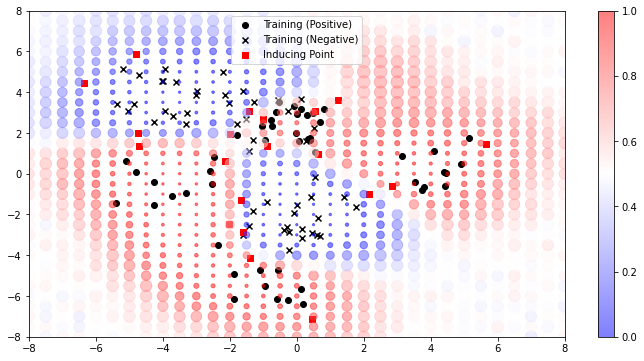

CPU times: user 20.4 s, sys: 1.17 s, total: 21.6 s
Wall time: 5.86 s


In [9]:
%%time
with torch.no_grad():
    Xnew = torch.tensor([[x, y] for x in np.linspace(-8, 8, 33) for y in np.linspace(-8, 8, 33)], dtype = torch.get_default_dtype())
    fnew, ynew = estimator(Xnew, 100)
    pnew = torch.sigmoid(fnew)
    pnew_mean = pnew.mean(axis = 0)
    pnew_std = pnew.std(axis = 0)

    s = ((pnew_std - pnew_std[:, 0].min()) / pnew_std[:, 0].std() + 0.1) * 50
    plt.figure(figsize = (12, 6))
    plt.scatter(x = X[y[:, 0] == 1, 0], y = X[y[:, 0] == 1, 1], c = "black", marker = "o", label = "Training (Positive)")
    plt.scatter(x = X[y[:, 0] == 0, 0], y = X[y[:, 0] == 0, 1], c = "black", marker = "x", label = "Training (Negative)")
    plt.scatter(x = estimator.Z[:, 0], y = estimator.Z[:, 1], c = "red", marker = "s", label = "Inducing Point")
    plt.scatter(x = Xnew[:, 0], y = Xnew[:, 1], c = pnew_mean[:, 0], s = s, marker = "o", cmap = "bwr", norm = Normalize(vmin = 0, vmax = 1), alpha = 0.5)
    plt.xlim(-8, 8)
    plt.ylim(-8, 8)
    plt.colorbar()
    plt.legend()
    plt.show()

### ハイパーパラメーター

In [10]:
estimator.kernel.scale

tensor(1.5665, grad_fn=<AddBackward0>)

### 変分パラメーター

In [11]:
estimator.Z

Parameter containing:
tensor([[-1.0126,  2.6733],
        [-6.3576,  4.4496],
        [ 5.6517,  1.4790],
        [-0.8976,  1.3527],
        [-2.1514,  0.6198],
        [-4.7439,  1.9798],
        [-1.4120, -4.1348],
        [-1.6655, -1.3070],
        [ 0.5528,  3.0593],
        [-2.0266, -2.4858],
        [ 1.2403,  3.6371],
        [-4.8138,  5.8754],
        [ 2.8424, -0.5953],
        [-1.4371,  3.0753],
        [-4.7274,  1.3817],
        [-1.9892,  1.9587],
        [ 0.4678, -7.1447],
        [ 2.1688, -0.9766],
        [ 0.6230,  0.9715],
        [-1.5937, -2.8591]], requires_grad=True)

In [12]:
estimator.u_loc

Parameter containing:
tensor([[ 1.3762, -1.8971,  2.4721, -0.2123,  1.2816, -1.5637,  1.6930, -1.0158,
          1.3592,  0.8313,  0.3494, -2.1255,  2.4628, -1.2615,  1.7167, -0.4334,
          2.1062, -1.5238,  0.6774, -2.0141]], requires_grad=True)

In [13]:
estimator.u_cov

tensor([[[ 1.2012e-01, -2.6391e-02, -2.4601e-03,  2.3627e-02, -1.7737e-02,
          -1.8098e-02,  2.1746e-02, -2.3894e-03, -7.9553e-02,  2.0723e-02,
           2.8995e-03,  2.7976e-02, -2.0397e-02,  1.0390e-01, -3.0745e-02,
           5.3109e-03,  1.0747e-02,  6.7161e-03, -4.4421e-02,  3.3053e-02],
         [-2.6391e-02,  3.5690e-01, -2.9556e-02, -5.4567e-02, -9.2550e-04,
          -2.1403e-02, -4.1447e-02,  2.3576e-02,  1.3254e-01,  1.3559e-02,
          -1.4674e-02,  7.3007e-03,  3.7802e-02,  3.1037e-02, -1.0824e-03,
           6.8036e-04,  3.2433e-02,  1.3584e-03, -1.2390e-01,  2.1414e-03],
         [-2.4601e-03, -2.9556e-02,  2.9786e-01,  7.9292e-02, -7.4058e-02,
          -1.0039e-02, -3.6895e-02,  2.0351e-03, -3.3010e-02,  3.6822e-02,
           4.7444e-02,  3.4766e-02, -2.5909e-02, -6.7662e-02,  6.2006e-03,
           1.4890e-02, -3.5860e-02, -4.7256e-02,  1.3291e-01,  1.2341e-02],
         [ 2.3627e-02, -5.4567e-02,  7.9292e-02,  2.0003e-01,  3.0444e-02,
           4.7967e-02,